In [1]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
import kagglehub
import matplotlib.pyplot as plt

In [2]:
# Download latest version
path = kagglehub.dataset_download("austinreese/craigslist-carstrucks-data")

In [3]:
vehicles = pd.read_csv(path + '/vehicles.csv')

In [4]:
vehicles.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [5]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

In [6]:
#so county is completely null ?
vehicles['county'].nunique()

0

<hr style="border:2px solid black;">

## <center>Data Cleaning

In [7]:
#dropping the empty column
vehicles = vehicles.drop('county', axis= 1)

In [8]:
#checking if 'posting_date' column useful for time analysis
# Convert the posting_date column to datetime format
vehicles['posting_date'] = pd.to_datetime(vehicles['posting_date'], errors='coerce', utc= True)
valid_dates = vehicles['posting_date'].dropna()
# Get the date range
date_range = (valid_dates.min(), valid_dates.max())
print(f"Date range: {date_range}")

Date range: (Timestamp('2021-04-04 07:00:25+0000', tz='UTC'), Timestamp('2021-05-05 04:24:09+0000', tz='UTC'))


<small>the date range is too narrow to provide meaningful insights</small>

In [9]:
#these columns doesn't look useful for analysis
columns_to_drop = ['url', 'region_url', 'VIN', 'image_url', 'description', 'posting_date']
vehicles = vehicles.drop(columns=columns_to_drop)

In [10]:
#looking for null values
vehicles.isna().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
drive           130567
size            306361
type             92858
paint_color     130203
state                0
lat               6549
long              6549
dtype: int64

In [11]:
vehicles.dtypes

id                int64
region           object
price             int64
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
drive            object
size             object
type             object
paint_color      object
state            object
lat             float64
long            float64
dtype: object

In [12]:
categorical_cols = vehicles.select_dtypes(exclude= 'number').columns

In [13]:
#Identify numerical columns
numerical_cols = vehicles.select_dtypes('number').columns

In [14]:
vehicles[categorical_cols].isna().sum()

region               0
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
title_status      8242
transmission      2556
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

In [15]:
# Impute missing values in not numerical columns using mode (grouped by manufacturer)
for col in categorical_cols:
    modes = vehicles.groupby('manufacturer', observed=False)[col].apply\
    (lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    vehicles[col] = vehicles[col].fillna(vehicles['manufacturer'].map(modes))

In [16]:
# Impute by state for rows with missing manufacturer
for col in categorical_cols:
    modes = vehicles.groupby('state', observed=False)[col].apply\
    (lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    vehicles[col] = vehicles[col].fillna(vehicles['state'].map(modes))

In [17]:
#Impute missing values in numerical columns using IterativeImputer (grouped by manufacturer)
def impute_numerical(df, numerical_cols):
    iter_imputer = IterativeImputer(max_iter = 10, random_state= 42)
    # Apply Iterative Imputer to numerical columns (grouped by manufacturer)
    for col in numerical_cols:
        for group in df['manufacturer'].unique():
            group_data = df[df['manufacturer'] == group]
            imputed_values = iter_imputer.fit_transform(group_data[[col]])
            df.loc[df['manufacturer'] == group, col] = imputed_values[:, 0]

    return df

In [18]:
impute_numerical(vehicles, numerical_cols)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long
0,7222695916,prescott,6000,2009.440256,ford,silverado 1500,good,6 cylinders,gas,111755.335484,clean,automatic,4wd,full-size,sedan,white,az,38.508270,-94.438416
1,7218891961,fayetteville,11900,2009.666159,chevrolet,silverado 1500,good,8 cylinders,gas,105993.655507,clean,automatic,4wd,full-size,pickup,white,ar,38.797477,-94.413448
2,7221797935,florida keys,21000,2009.440256,ford,f-150,good,6 cylinders,gas,111755.335484,clean,automatic,fwd,full-size,sedan,white,fl,38.508270,-94.438416
3,7222270760,worcester / central MA,1500,2009.440256,ford,f-150,good,4 cylinders,gas,111755.335484,clean,automatic,4wd,full-size,sedan,white,ma,38.508270,-94.438416
4,7210384030,greensboro,4900,2009.440256,ford,f-150,good,6 cylinders,gas,111755.335484,clean,automatic,4wd,full-size,sedan,white,nc,38.508270,-94.438416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,7301591192,wyoming,23590,2019.000000,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.000000,clean,other,fwd,mid-size,sedan,white,wy,33.786500,-84.445400
426876,7301591187,wyoming,30590,2020.000000,volvo,s60 t5 momentum sedan 4d,good,5 cylinders,gas,12029.000000,clean,other,fwd,full-size,sedan,red,wy,33.786500,-84.445400
426877,7301591147,wyoming,34990,2020.000000,cadillac,xt4 sport suv 4d,good,6 cylinders,diesel,4174.000000,clean,other,4wd,full-size,hatchback,white,wy,33.779214,-84.411811
426878,7301591140,wyoming,28990,2018.000000,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.000000,clean,other,fwd,mid-size,sedan,silver,wy,33.786500,-84.445400


In [19]:
vehicles.isna().sum()

id              0
region          0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
state           0
lat             0
long            0
dtype: int64

In [20]:
vehicles[categorical_cols].nunique()

region            404
manufacturer       42
model           29667
condition           6
cylinders           8
fuel                5
title_status        6
transmission        3
drive               3
size                4
type               13
paint_color        12
state              51
dtype: int64

In [21]:
# Checking if 'model' column is benefecial to change to category dtype since it has a lot of unique values
print(vehicles['model'].memory_usage())


# Convert to category
vehicles['model'] = vehicles['model'].astype('category')


# Check memory after
print(vehicles['model'].memory_usage())

3415172
2148036


In [22]:
vehicles[categorical_cols] = vehicles[categorical_cols].astype('category')

<hr style="border:2px solid black;">

##  <center>Which manufacturers dominate the used car market?

In [23]:
manufacturer_counts = vehicles['manufacturer'].value_counts()
manufacturer_percentage = (manufacturer_counts / manufacturer_counts.sum()) * 100


In [24]:
manufacturer_summary = pd.DataFrame({
    'Total Listings': manufacturer_counts,
    'Market Share (%)': manufacturer_percentage
})

In [25]:
manufacturer_summary.sort_values(by='Total Listings', ascending=False)

,Total Listings,Market Share (%)
manufacturer,,
ford,87543,20.507637
chevrolet,56032,13.125937
toyota,34322,8.040199
honda,21269,4.982431
nissan,19067,4.466595
jeep,19014,4.454179
ram,18342,4.296758
gmc,16785,3.932018
bmw,14699,3.443356


In [26]:
manufacturer_summary.sort_values(by='Total Listings', ascending=False).index[:3].tolist()

['ford', 'chevrolet', 'toyota']

#### so dominant manufacturers are ford, chevrolet and toyota

<hr style="border:1px solid black;">

## <center>What vehicle types are most commonly sold?

In [27]:
vehicles['type'].value_counts()

type
sedan          132024
SUV             84126
pickup          83940
truck           35307
other           22166
coupe           19237
hatchback       17089
wagon           10751
van              8548
convertible      7741
mini-van         4825
offroad           609
bus               517
Name: count, dtype: int64

In [28]:
# Total number of listings per vehicle type
type_counts = vehicles['type'].value_counts()

# Percentage of each vehicle type
type_percentage = (type_counts / type_counts.sum()) * 100

# Combine into a DataFrame for better representation
type_summary = pd.DataFrame({
    'Total Listings': type_counts,
    'Market Share (%)': type_percentage
})

# Sort by total listings in descending order
type_summary = type_summary.sort_values(by='Total Listings', ascending=False)

type_summary


,Total Listings,Market Share (%)
type,,
sedan,132024,30.927661
SUV,84126,19.707178
pickup,83940,19.663606
truck,35307,8.270943
other,22166,5.192560
coupe,19237,4.506419
hatchback,17089,4.003233
wagon,10751,2.518506
van,8548,2.002436


<hr style="border:1px solid black;">

# <center> Top manufacturers by median price

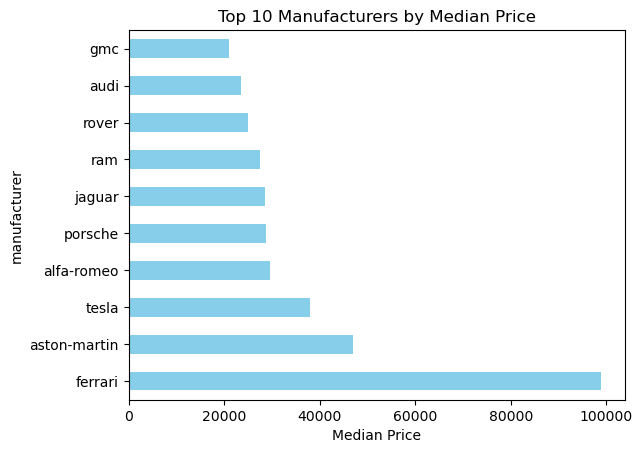

In [29]:
# Calculate median price by manufacturer
top_manufacturers = vehicles.groupby('manufacturer', observed= True)['price'].median().nlargest(10)

# Plot the top 10 manufacturers by median price
top_manufacturers.plot(kind='barh', color='skyblue')
plt.title('Top 10 Manufacturers by Median Price')
plt.xlabel('Median Price')
plt.show()

#### Ferrari has the highest median price among the top 10 manufacturers, followed by Aston Martin, Tesla, and others. 

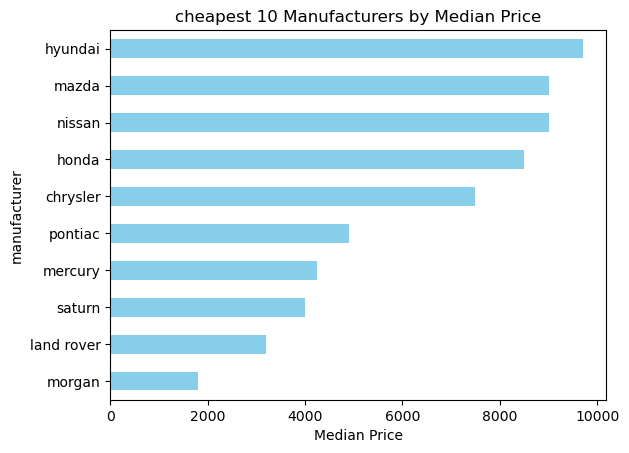

In [30]:
# Calculate median price by manufacturer
cheapest_manufacturers = vehicles.groupby('manufacturer', observed= True)['price'].median().nsmallest(10)

# Plot the cheapest 10 manufacturers by median price
cheapest_manufacturers.plot(kind='barh', color='skyblue')
plt.title('cheapest 10 Manufacturers by Median Price')
plt.xlabel('Median Price')
plt.show()

#### morgan has the cheapest median price followed by land rover,saturn. and others. 

<hr style="border:1px solid black;">

## <center>Which regions should a used car dealership focus on if they want to maximize revenue from high-value car sales, and which regions are better suited for budget vehicle promotions?

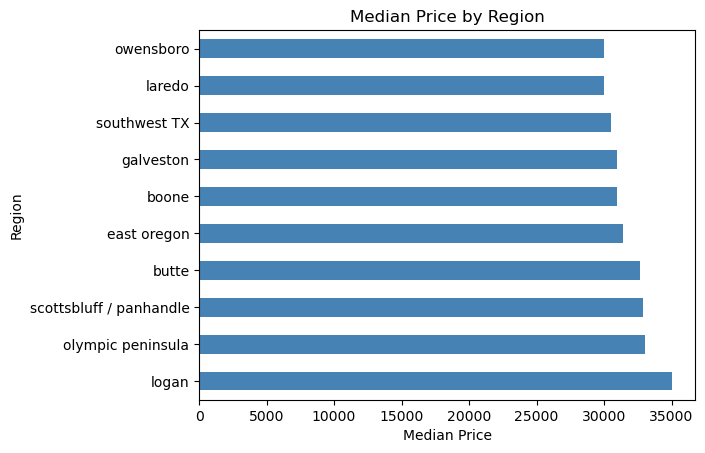

In [31]:
# Calculate median price by region
region_prices = vehicles.groupby('region', observed= True)['price'].median().nlargest(10)

# Plot the median price by region
region_prices.plot(kind='barh', color='steelblue')
plt.title('Median Price by Region')
plt.xlabel('Median Price')
plt.ylabel('Region')
plt.show()

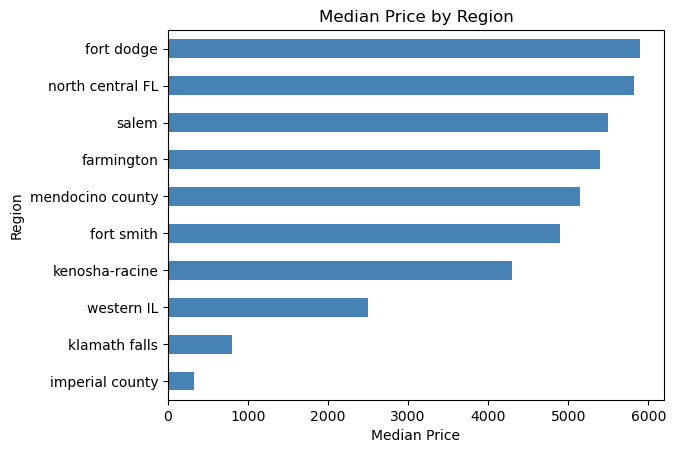

In [32]:
# Calculate median price by region
low_region_prices = vehicles.groupby('region', observed= True)['price'].median().nsmallest(10)

# Plot the median price by region
low_region_prices.plot(kind='barh', color='steelblue')
plt.title('Median Price by Region')
plt.xlabel('Median Price')
plt.ylabel('Region')
plt.show()

**Maximizing Revenue from High-Value Car Sales :**

Dealerships should prioritize regions such as logan, olympic peninsula, where the median prices for vehicles are significantly higher. These regions indicate a market for premium or luxury vehicles, suggesting customers are willing to pay a premium for better condition, newer, or high-end cars.<br><br>
**Promoting Budget Vehicles :**

Regions like Imperial County and Klamath Falls are ideal for promoting budget or economy vehicles due to their low median prices. This likely reflects a preference for affordability or an overall lower purchasing power in these areas.


<hr style="border:1px solid black;">

## <center>How does the transmission type vary across different vehicle conditions?

<Figure size 1000x600 with 0 Axes>

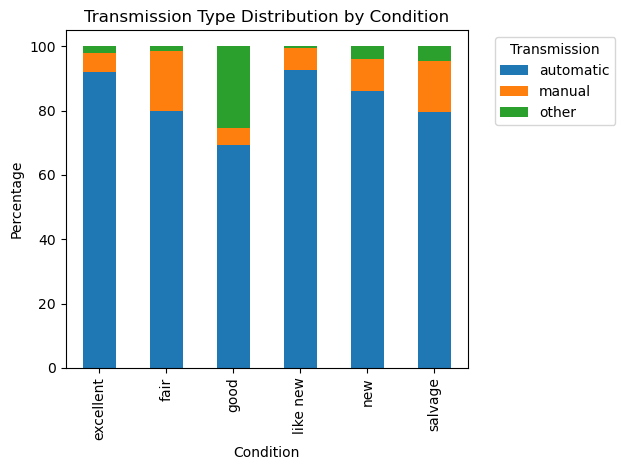

In [33]:
# Transmission distribution by condition
transmission_condition = vehicles.groupby(\
                                      'condition', observed= True)['transmission'].value_counts(normalize=True).unstack() * 100


plt.figure(figsize=(10, 6))
transmission_condition.plot(kind='bar', stacked=True)
plt.title('Transmission Type Distribution by Condition')
plt.xlabel('Condition')
plt.ylabel('Percentage')
plt.legend(title='Transmission', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Across ALL conditions, automatic transmission is the most prevalent as  roughly 80-90% of vehicles in each condition have automatic transmission

#### but manual transmission Consistently low percentage across all conditions as around 10-15% of vehicles have manual transmission
<br>
Market heavily prefers automatic transmission<br>
Transmission type doesn't seem to dramatically change across vehicle conditions<br>
<u>Potential buying/selling strategy:</u><br> Focus on automatic transmission vehicles

<hr style="border:1px solid black;">

## <center>What fuel type has the most vehicles and which fuel type has the highest median price?

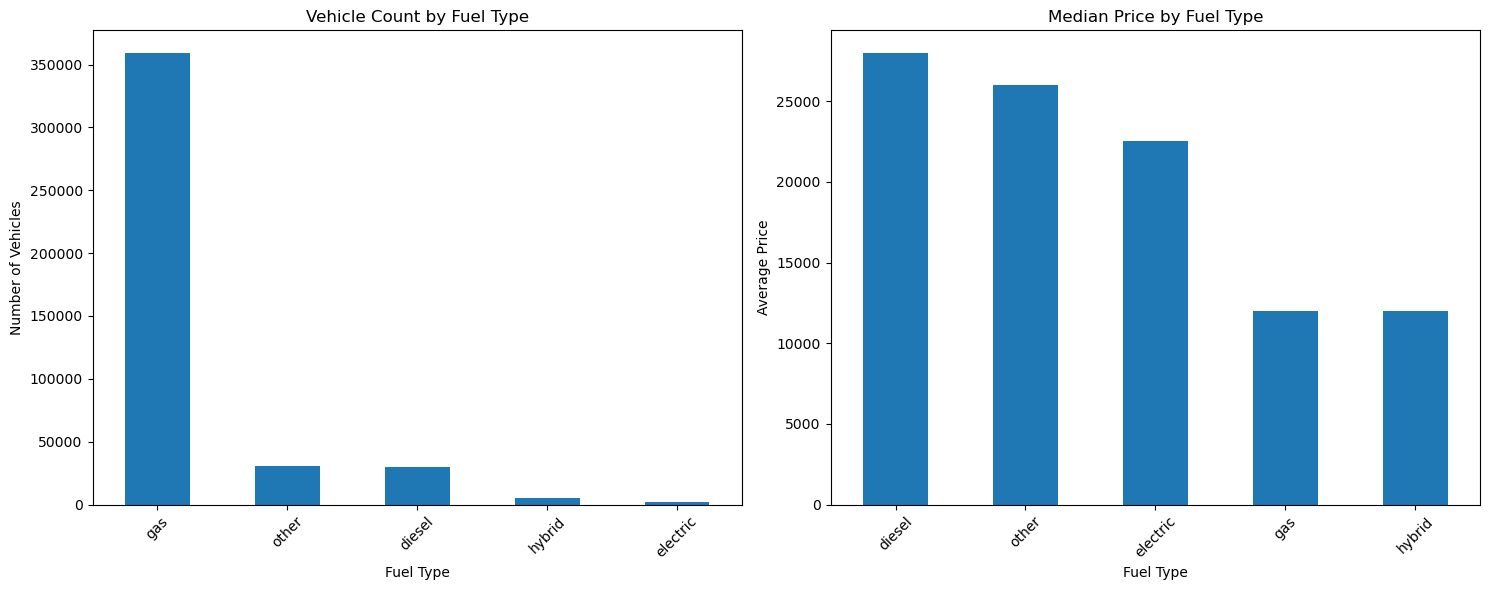

Fuel Type Price Statistics:
           count       mean   median          std
fuel                                             
diesel     30062  118177.69  27990.0  10378576.07
electric    1698   24648.36  22544.5     17198.26
gas       359222   73431.14  11999.0  12771171.84
hybrid      5170   14582.43  11995.0     11479.14
other      30728   66811.40  25990.0   7043045.82


In [34]:
# Fuel Type Distribution and Price Analysis
plt.figure(figsize=(15,6))


# Subplot 1: Fuel Type Counts
plt.subplot(1,2,1)
fuel_counts = vehicles['fuel'].value_counts()
fuel_counts.plot(kind='bar')
plt.title('Vehicle Count by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Number of Vehicles')
plt.xticks(rotation=45)


# Subplot 2: Median Price by Fuel Type
plt.subplot(1,2,2)
fuel_avg_price = vehicles.groupby('fuel', observed= True)['price'].median().sort_values(ascending=False)
fuel_avg_price.plot(kind='bar')
plt.title('Median Price by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Average Price')
plt.xticks(rotation=45)


plt.tight_layout()
plt.show()


# Additional Statistical Summary
print("Fuel Type Price Statistics:")
print(vehicles.groupby('fuel', observed= True)['price'].agg(['count', 'mean', 'median', 'std']).round(2))

#### Based on the analysis, gas-powered vehicles dominate the market with 359,222 units, while diesel vehicles command the highest median price at $27,990.